In [1]:
from __future__ import division

import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
#%matplotlib notebook
%matplotlib inline

## Problem 1: Logistic Regression

### 1.1 Scatter Plots
Load the Iris data set, and split it into two different binary prediction problems: Class 0 vs Class 1 ("set A") and Class 1 vs Class 2 ("set B").

In [2]:
iris = np.genfromtxt("data/iris.txt",delimiter=None)
X, Y = iris[:,0:2], iris[:,-1]   # get first two features & target
X,Y  = ml.shuffleData(X,Y)       # reorder randomly (important later)
X,_  = ml.transforms.rescale(X)                # works much better on rescaled data

XA, YA = X[Y<2,:], Y[Y<2]        # get class 0 vs 1
XB, YB = X[Y>0,:], Y[Y>0]        # get class 1 vs 2

If we visualize these two data sets, we can easily see that set A is linearly separable (there is a line which could correctly classify all the data), while set B is not.

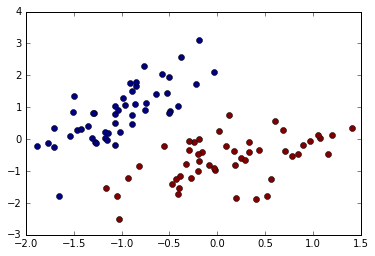

In [3]:
ml.plotClassify2D(None,XA,YA)
plt.show()

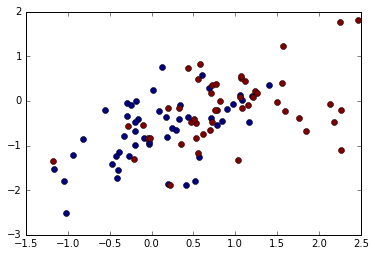

In [4]:
ml.plotClassify2D(None,XB,YB)
plt.show()

### 1.2 Plot Boundary

I'll first show the implementation of the functions, and then replace it in the learner and show the plots separately.

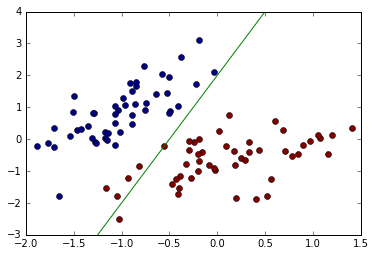

In [5]:
# Should go in your logistic2 class:
def myplotBoundary(self, X,Y):
    hld=plt.hold(); plt.hold(True);
    ml.plotClassify2D(None,X,Y)  # plot data alone
    ax = plt.axis()
    Xmin,Xmax = np.min(X[:,0]), np.max(X[:,0])
    x1b = np.array([Xmin,Xmax])
    x2b = (-self.theta[0]-self.theta[1]*x1b)/self.theta[2]
    plt.plot(x1b,x2b,'g-')
    plt.axis(ax); plt.hold(hld);
    
import logisticClassify2 as lc2
class logistic2(lc2.logisticClassify2): # override methods here for solution doc
    plotBoundary = myplotBoundary

# For dataset A
learnerA = logistic2()
learnerA.classes = np.unique(YA)
learnerA.theta = np.array( [0.5,1,-0.25] )
myplotBoundary(learnerA,XA,YA)

plt.show()

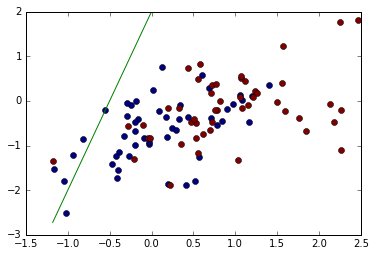

In [6]:
# For dataset B
learnerB = logistic2()
learnerB.classes = np.unique(YB)
learnerB.theta = np.array( [0.5,1,-0.25] )
myplotBoundary(learnerB,XB,YB)

plt.show()

### 1.3 Predict

In [7]:
# Should go in your logistic2 class:
def mypredict(self,X):
    Z = self.theta[0] + X.dot(self.theta[1:])
    Y01 = (Z > 0).astype(int)
    Y = np.asarray(self.classes)[Y01]
    return Y

import logisticClassify2 as lc2
class logistic2(lc2.logisticClassify2): # override methods here for solution doc
    plotBoundary = myplotBoundary
    predict = mypredict

In [8]:
# For dataset A
learnerA = logistic2()
learnerA.classes = np.unique(YA)
learnerA.theta = np.array( [0.5,1,-0.25] )
learnerA.err(XA, YA)

0.050505050505050504

In [9]:
# For dataset B
learnerB = logistic2()
learnerB.classes = np.unique(YB)
learnerB.theta = np.array( [0.5,1,-0.25] )
learnerB.err(XB, YB)

0.46464646464646464

### 1.4 Verifying the Boundary

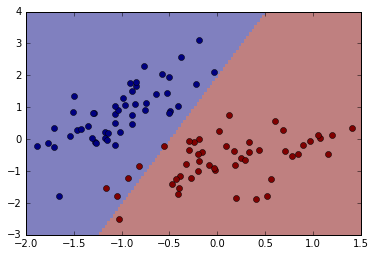

In [10]:
ml.plotClassify2D(learnerA,XA,YA)
plt.show()

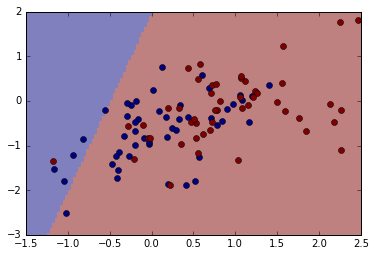

In [11]:
ml.plotClassify2D(learnerB,XB,YB)
plt.show()

That value of theta is not bad for data set A.  
Using the same value of theta to predict on set B obviously doesn't work as well.

### 1.5 Gradient of NLL

Our NLL loss is:
$$J_j(\theta) = - \begin{cases} \log( \sigma(x^{(i)} \cdot \theta)) & \mbox{if}\  y^{(i)}=1 \\ \log(1-\sigma(x^{(i)} \cdot \theta)) & \mbox{if}\  y^{(i)}=0 \end{cases}$$

Thus, its gradient is:
$$\nabla J_j(\theta) = - \begin{cases} (1-\sigma(x^{(i)} \cdot \theta)) \ x^{(i)} & \mbox{if}\  y^{(i)}=1 \\ -\sigma(x^{(i)}\cdot \theta) \ x^{(i)} & \mbox{if}\  y^{(i)}=0 \end{cases}$$


### 1.6 Train Function

In [12]:
def mytrain(self,X,Y, initStep=1.,stopTol=1e-4,stopEpochs=5000,plot=None):
    """ Train the logistic regression using stochastic gradient descent """
    M,N = X.shape;                     # initialize the model if necessary:
    self.classes = np.unique(Y);       # Y may have two classes, any values
    XX = np.hstack((np.ones((M,1)),X)) # XX is X, but with an extra column of ones
    YY = ml.toIndex(Y,self.classes);   # YY is Y, but with canonical values 0 or 1
    if len(self.theta)!=N+1: self.theta=np.random.rand(N+1);
    # init loop variables:
    epoch=0; done=False; Jnll=[]; J01=[]; 
    while not done:
        stepsize, epoch = initStep*2.0/(2.0+epoch), epoch+1; # update stepsize
        # Do an SGD pass through the entire data set:
        for i in np.random.permutation(M):
            ri = XX[i].dot(self.theta)     # compute linear response r(x)
            si    = 1./(1.+np.exp(-ri))
            gradi = -(1-si)*XX[i,:] if YY[i] else si*XX[i,:]  # compute gradient of NLL loss
            self.theta -= stepsize * gradi;  # take a gradient step

        J01.append( self.err(X,Y) )  # evaluate the current error rate 

        ## compute surrogate loss (logistic negative log-likelihood)
        ##  Jnll = sum_i [ (log si) if yi==1 else (log(1-si)) ]
        S = 1./(1.+np.exp(-(XX.dot(self.theta))))
        Jsur = -np.mean(YY*np.log(S)+(1-YY)*np.log(1-S))
        Jnll.append( Jsur ) # evaluate the current NLL loss
        plt.figure(1); plt.clf(); plt.plot(Jnll,'b-',J01,'r-'); plt.draw();    # plot losses
        if N==2: plt.figure(2); plt.clf(); self.plotBoundary(X,Y); plt.draw(); # & predictor if 2D
        plt.pause(.01);                    # let OS draw the plot

        ## For debugging: you may want to print current parameters & losses
        # print self.theta, ' => ', Jsur[-1], ' / ', J01[-1]  
        # raw_input()   # pause for keystroke

        # TODO check stopping criteria: exit if exceeded # of epochs ( > stopEpochs)
        done = epoch>=stopEpochs or (epoch>1 and abs(Jnll[-1]-Jnll[-2])<stopTol);   
        # or if Jnll not changing between epochs ( < stopTol )


### 1.7 Running the Classifier

In [13]:
import logisticClassify2 as lc2
class logistic2(lc2.logisticClassify2): # override methods here for solution doc
    plotBoundary = myplotBoundary
    predict = mypredict
    train = mytrain

Training error rate:  0.010101010101


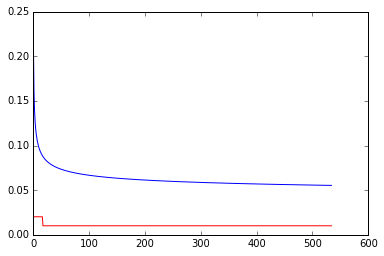

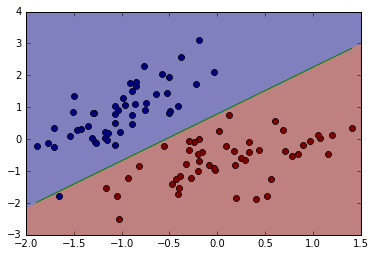

In [14]:
learnerA = logistic2()
learnerA.theta = np.array([0.,0.,0.]);
learnerA.train(XA,YA,initStep=1e-1,stopEpochs=1000,stopTol=1e-5);

ml.plotClassify2D(learnerA,XA,YA)
print("Training error rate: ",learnerA.err(XA,YA))

plt.show()

Training error rate:  0.252525252525


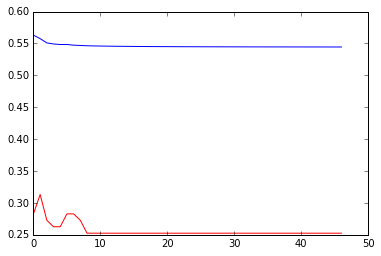

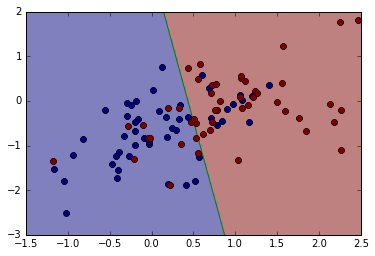

In [15]:
learnerB = logistic2()
learnerB.theta = np.array([0.,0.,0.]);
learnerB.train(XB,YB,initStep=1e-1,stopEpochs=1000,stopTol=1e-5);

ml.plotClassify2D(learnerB,XB,YB)
print("Training error rate: ",learnerB.err(XB,YB))

plt.show()

### 1.8 Extra Credit: Regularization

The additional term to the loss function is $+\alpha||\theta||^2_2$, the gradient for which is $+2\alpha\theta$.

In [16]:
def myregtrain(self,X,Y, initStep=1.,stopTol=1e-4,stopEpochs=5000,alpha=0.,plot=None):
    """ Train the logistic regression using stochastic gradient descent """
    M,N = X.shape;                     # initialize the model if necessary:
    self.classes = np.unique(Y);       # Y may have two classes, any values
    XX = np.hstack((np.ones((M,1)),X)) # XX is X, but with an extra column of ones
    YY = ml.toIndex(Y,self.classes);   # YY is Y, but with canonical values 0 or 1
    if len(self.theta)!=N+1: self.theta=np.random.rand(N+1);
    # init loop variables:
    epoch=0; done=False; Jnll=[]; J01=[]; 
    while not done:
        stepsize, epoch = initStep*2.0/(2.0+epoch), epoch+1; # update stepsize
        # Do an SGD pass through the entire data set:
        for i in np.random.permutation(M):
            ri = XX[i].dot(self.theta)     # compute linear response r(x)
            si    = 1./(1.+np.exp(-ri))
            gradi = -(1-si)*XX[i,:] if YY[i] else si*XX[i,:]  # compute gradient of NLL loss
            gradi += 2.*alpha*self.theta # gradient of the additional L2 regularization term
            self.theta -= stepsize * gradi;  # take a gradient step

        J01.append( self.err(X,Y) )  # evaluate the current error rate 

        ## compute surrogate loss (logistic negative log-likelihood)
        ##  Jnll = sum_i [ (log si) if yi==1 else (log(1-si)) ]
        S = 1./(1.+np.exp(-(XX.dot(self.theta))))
        Jsur = -np.mean(YY*np.log(S)+(1-YY)*np.log(1-S))
        Jnll.append( Jsur ) # evaluate the current NLL loss
        plt.figure(1); plt.clf(); plt.plot(Jnll,'b-',J01,'r-'); plt.draw();    # plot losses
        if N==2: plt.figure(2); plt.clf(); self.plotBoundary(X,Y); plt.draw(); # & predictor if 2D
        plt.pause(.01);                    # let OS draw the plot

        ## For debugging: you may want to print current parameters & losses
        # print self.theta, ' => ', Jsur[-1], ' / ', J01[-1]  
        # raw_input()   # pause for keystroke

        # TODO check stopping criteria: exit if exceeded # of epochs ( > stopEpochs)
        done = epoch>=stopEpochs or (epoch>1 and abs(Jnll[-1]-Jnll[-2])<stopTol);   
        # or if Jnll not changing between epochs ( < stopTol )

In [17]:
import logisticClassify2 as lc2
class logistic2(lc2.logisticClassify2): # override methods here for solution doc
    plotBoundary = myplotBoundary
    predict = mypredict
    regtrain = myregtrain

Training error rate:  0.0808080808081


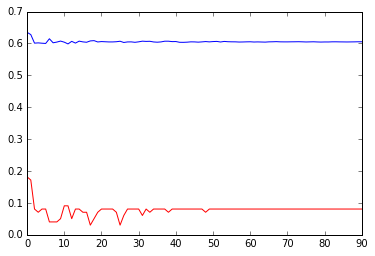

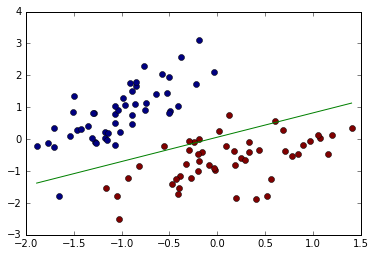

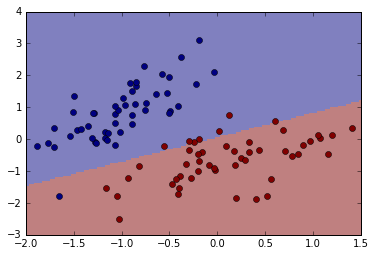

In [18]:
learnerA = logistic2()
learnerA.theta = np.array([0.,0.,0.]);
learnerA.regtrain(XA,YA,initStep=1e-1,stopEpochs=1000,stopTol=1e-5,alpha=1.);

plt.figure(); ml.plotClassify2D(learnerA,XA,YA)
print("Training error rate: ",learnerA.err(XA,YA))

Training error rate:  0.272727272727


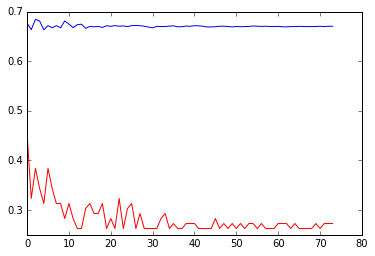

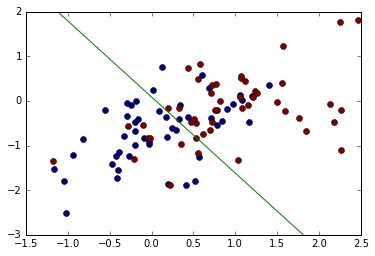

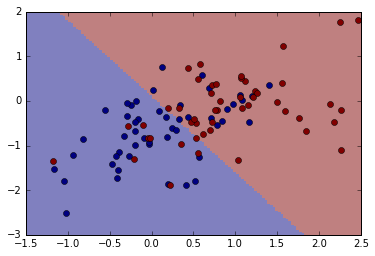

In [19]:
learnerB = logistic2()
learnerB.theta = np.array([0.,0.,0.]);
learnerB.regtrain(XB,YB,initStep=1e-1,stopEpochs=1000,stopTol=1e-5,alpha=1.);

plt.figure(); ml.plotClassify2D(learnerB,XB,YB)
print("Training error rate: ",learnerB.err(XB,YB))


## Problem 2: Shattering & VC Dimension


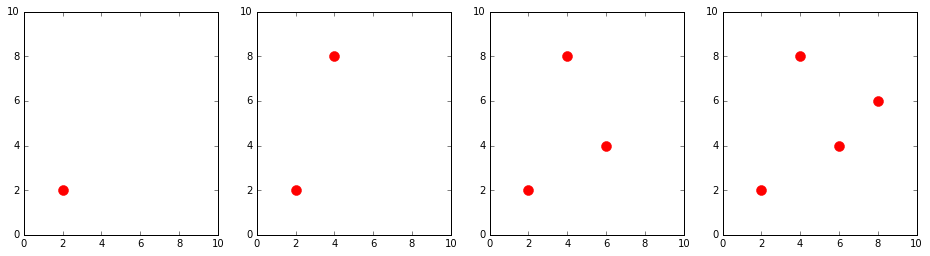

In [20]:
f,axs = plt.subplots(1,4, figsize=(16,4))
X=np.array( [[2,2],[4,8],[6,4],[8,6]] )
for i in range(4): 
    axs[i].plot(X[:i+1,0],X[:i+1,1],'r.',ms=20) 
    axs[i].axis([0,10,0,10])
    
plt.show()

**(1)** 

This learner is a standard peceptron on one feature (so, two parameters).  It has VC dimension 2;
its decision boundaries are vertical lines in the two-dimensional feature space 
(e.g., a solution to $a + b x_1 = 0$), with either side able to take either class value.
Hence, it can shatter either (a) or (b) but not (c) or (d). For counter example to (c), consider +1,-1,+1 labeling.

**(2)**

This learner has three parameters, but you can see that they're not working independently.  If I replace
$\alpha = a*b$ and $\beta = c/a$, there are really only two independently set-able parameters, so you
should guess VC dimension 2.  To reason further, this is a linear classifier with no constant (bias) term;
so its decision boundary will be a line passing through $(0,0)$, and (by changing the sign of $a$) it can
predict either class on either side.  Shattering (b) is straightforward; if the data signs differ, the line
will pass between them.  But (c) is not shattered; if $(4,8)$ and $(6,4)$ are both negative but $(2,2)$
is positive, no line passing through the origin can predict them correctly.

**(3)**

This learner has three parameters, so you should probably *guess* shattering (a)--(c), but let's work it
out.  Its decision boundaries are circles centered at an arbitrary point given by the parameters $(a,b)$;
since the value increases with distance from $(a,b)$, for $c<0$ we'll get class negative inside a circle,
and positive outside, with radius determined by $c$ (there's no way to get the reverse).  So, to shatter (b),
for example, if only one point were negative we would just center the circle on that point.  Similarly, for
(c), whichever two points are negative, we center and scale the circle so those two are inside, and the other
is not.  (The other cases are easy.)  But, for (d), we can't do it -- if the points at $(2,2)$ and $(8,6)$
are negative, any circle that contains both with also contain the others. Although we are not proving it formally, we know the VC-dimension is at least 3, but probably not 4.

**(4)**

These are two parallel lines, with the gap and the slope controllable. Note that since the decision is product of two threshold functions, the region *outside* the parallel lines will be +1 (either $+1\times+1$ or $-1\times-1$) and the region inside will be -1. Now these two lines can obviously act as one, so (a)--(c) for line is still shatterable. But for the given four points, it can shatter them as well, since the *XOR* condition can be inside the parallel lines. So the VC-dimension is $\geq$4 (though I suspect it is not 5).
